In [1]:
!pip install tensorflow opencv-python matplotlib --default-timeout 600

Defaulting to user installation because normal site-packages is not writeable


In [1]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.2
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
binary

In [2]:
import os
import tensorflow as tf

In [3]:
import cv2
import imghdr

In [4]:
data_dir = 'data'

In [5]:
image_exts = ['jpeg','jpg','png','bmp']

In [6]:
image_exts

['jpeg', 'jpg', 'png', 'bmp']

Removing inconsistent images, remove smaller images from the folders

In [7]:
for image_class in os.listdir(data_dir): #going through each folder in the directory
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)# try opening the image
            tip = imghdr.what(image_path) #get the type of image
            if tip not in image_exts:
                print("Incompatible image, removing")
                os.remove(image_path)
        except Exception as e:
            print("Error with image {}".format(image_path))

Loading Data

In [8]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 147 files belonging to 2 classes.


In [11]:
iterator = data.as_numpy_iterator() #looping through the data

In [12]:
batch = iterator.next()

In [13]:
batch[1]

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0])

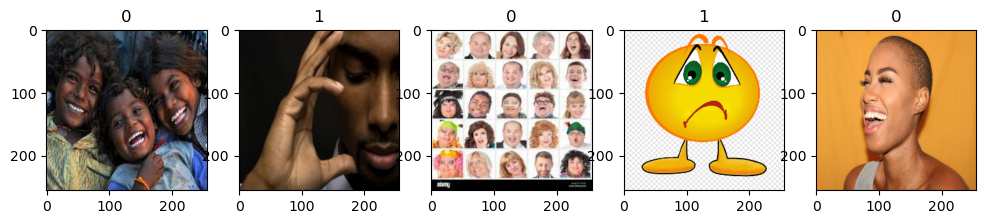

In [14]:
fig, ax = plt.subplots(ncols = 5, figsize = (12,10))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

From the above plot, we can find that class 0 is happy and class 1 is sad

Pre-Processing

Scaling the data

In [15]:
batch[0].max()

255.0

In [16]:
data = data.map(lambda x,y: (x/255,y))

In [17]:
batch = data.as_numpy_iterator().next()

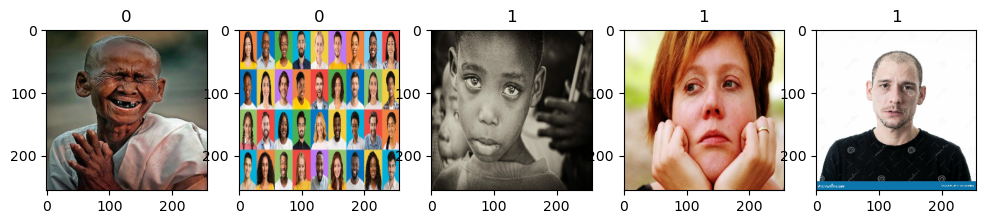

In [18]:
fig, ax = plt.subplots(ncols = 5, figsize = (12,10))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(float)) #here, we are using float as we have divided the values by 255
    ax[idx].title.set_text(batch[1][idx])

In [19]:
data.as_numpy_iterator().next()[0].min()

0.0

Splitting data into training and testing data

In [20]:
len(data)

5

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) + 1
print(train_size, val_size, test_size)

3 1 1


In [22]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Deep Learning Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16,(3,3),1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [26]:
model.compile('adam',loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [27]:
model.summary() # getting the details of our model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Training the model

In [28]:
logdir = 'logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [30]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 4s 1s/step - loss: 1.2609 - accuracy: 0.4688 - val_loss: 0.7844 - val_accuracy: 0.4375
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 0.7552 - accuracy: 0.4271 - val_loss: 0.6889 - val_accuracy: 0.5938
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.6965 - accuracy: 0.4271 - val_loss: 0.6886 - val_accuracy: 0.6875
Epoch 4/20
3/3 [==============================] - 3s 992ms/step - loss: 0.6826 - accuracy: 0.8125 - val_loss: 0.6827 - val_accuracy: 0.9062
Epoch 5/20
3/3 [==============================] - 4s 1s/step - loss: 0.6678 - accuracy: 0.7708 - val_loss: 0.6140 - val_accuracy: 0.6250
Epoch 6/20
3/3 [==============================] - 3s 994ms/step - loss: 0.6345 - accuracy: 0.6146 - val_loss: 0.5580 - val_accuracy: 0.7188
Epoch 7/20
3/3 [==============================] - 3s 1s/step - loss: 0.6115 - accuracy: 0.7083 - val_loss: 0.5538 - val_accuracy: 0.9688
Epoch 8/20
3/3 [===================

Performance Plotting

In [31]:
hist.history

{'loss': [1.260949969291687,
  0.7552129626274109,
  0.696483314037323,
  0.6826190948486328,
  0.667778491973877,
  0.6345379948616028,
  0.6114686727523804,
  0.5362064838409424,
  0.5068138241767883,
  0.5500575304031372,
  0.42972779273986816,
  0.37694403529167175,
  0.3020384609699249,
  0.2689362168312073,
  0.2120063304901123,
  0.16462434828281403,
  0.12496138364076614,
  0.0791904553771019,
  0.07739504426717758,
  0.09122556447982788],
 'accuracy': [0.46875,
  0.4270833432674408,
  0.4270833432674408,
  0.8125,
  0.7708333134651184,
  0.6145833134651184,
  0.7083333134651184,
  0.875,
  0.7395833134651184,
  0.6875,
  0.8125,
  0.8958333134651184,
  0.9583333134651184,
  0.875,
  0.90625,
  0.9166666865348816,
  0.9583333134651184,
  0.9791666865348816,
  0.9895833134651184,
  0.96875],
 'val_loss': [0.7844344973564148,
  0.6888936758041382,
  0.6885613203048706,
  0.6827292442321777,
  0.6139709949493408,
  0.5580448508262634,
  0.5538400411605835,
  0.49708518385887146,
 

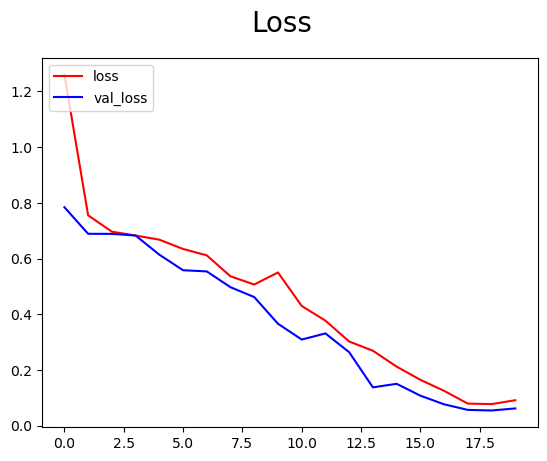

In [32]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'blue', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

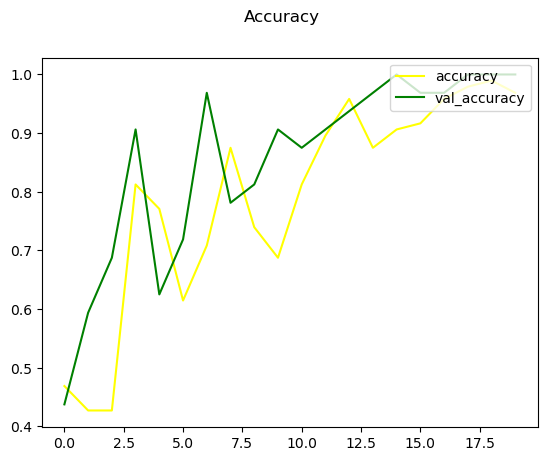

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color = 'yellow',label = 'accuracy')
plt.plot(hist.history['val_accuracy'],color = 'green',label = 'val_accuracy')
plt.suptitle('Accuracy')
plt.legend(loc = 'upper right')
plt.show()

Performance Evalutaion

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [40]:
pre = Precision()
rec = Recall()
BA = BinaryAccuracy()

In [42]:
for batch in test.as_numpy_iterator():
    X, y = batch
    ybar = model.predict(X)
    pre.update_state(y, ybar)
    rec.update_state(y, ybar)
    BA.update_state(y, ybar)

1/1 [==============================] - 0s 79ms/step


In [43]:
print(f'Precision:{pre.result().numpy()} Recall:{rec.result().numpy()} Accuracy: {BA.result().numpy()}')

Precision:1.0 Recall:0.9375 Accuracy: 0.9736841917037964


Testing on unknown data

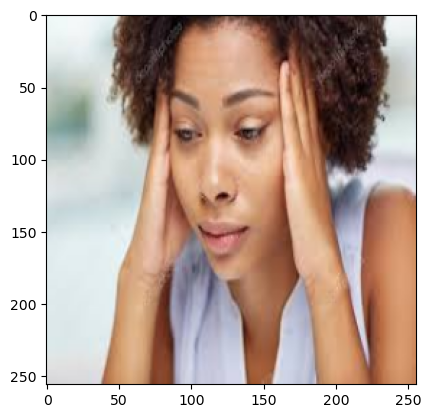

In [54]:
img = cv2.imread('data/test-1.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.image.resize(img,(256,256))
plt.imshow(img.numpy().astype(int))
plt.show()

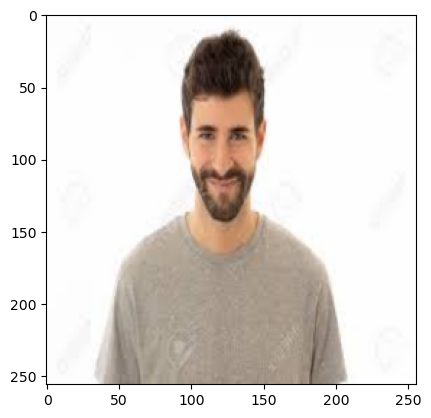

In [53]:
img1 = cv2.imread('data/test-2.jpeg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = tf.image.resize(img1,(256,256))
plt.imshow(img1.numpy().astype(int))
plt.show()

In [56]:
ybar1 = model.predict(np.expand_dims(img/255,0))
ybar1

1/1 [==============================] - 0s 32ms/step


array([[0.98694104]], dtype=float32)

Saving the Model

In [58]:
from tensorflow.keras.models import load_model

In [60]:
model.save(os.path.join('models','emotionrecogmodel.h5'))

In [62]:
new_model = load_model(os.path.join('models','emotionrecogmodel.h5'))

In [71]:
img2 = cv2.imread('data/test-3.jpeg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = tf.image.resize(img2, (256,256))

In [72]:
new_model.predict(np.expand_dims(img2/255,0))

1/1 [==============================] - 0s 31ms/step


array([[0.04024063]], dtype=float32)